In [23]:
import RVstab
import numpy as np
import matplotlib.pyplot as plt
import scipy

### First, let's use the code to generate a planetary system of two gas giants ($M_\mathrm{p} = M_\mathrm{Jupiter}$) in a mean-motion resonance

In [24]:
sys = RVstab.RVSystem(mstar=1.0)

sys.add_planet(mass=1e0,e=0.1,per=200,l=30,omega=0) #Start the planet slightly off of MMR
sys.add_planet(mass=1e0,e=0.1,per=300,l=0,omega=180)
sys.epoch=0

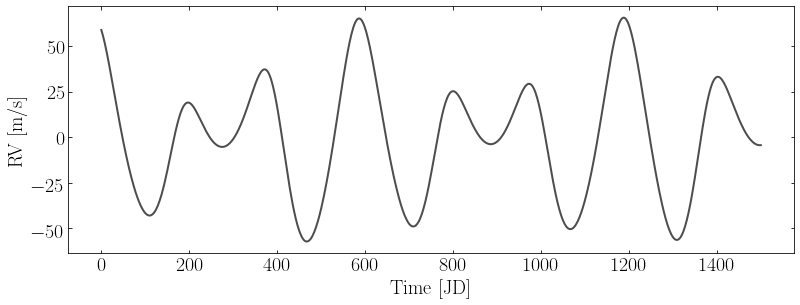

In [25]:
times,RVs = sys.plot_RV(plot_data=False,ret_data=True,periods=5) # Plot the RV signal and get the times and RV values

### We can use the plot_phi function to verify that the resonant angles actually librate

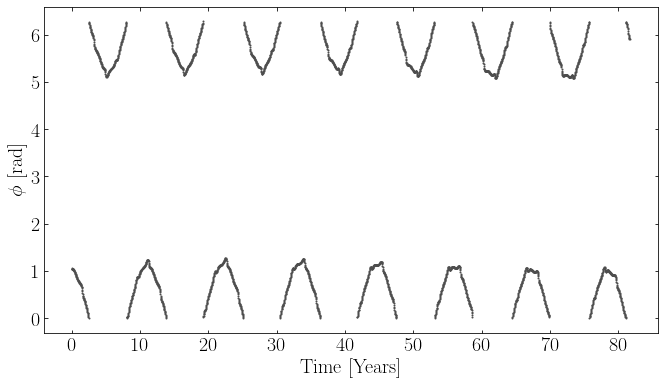

In [26]:
_,_ = sys.plot_phi(3,2,1,0,periods=100)

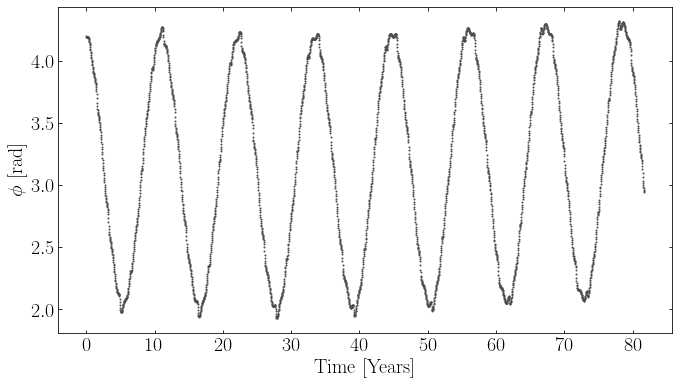

In [27]:
_, _ = sys.plot_phi(3,2,0,1,periods=100)

### Let's randomly pull 100 points from the curve and add Gaussian noise with amplitude 10 m/s. We'll only give each data point 5 m/s of error though, for reasons we'll see below.

In [28]:
inds = np.random.choice(range(len(times)),replace=False,size=100) 
inds = inds[np.argsort(inds)]

error_amp = 7.5
data_err = 5

JDs = times[inds]
vels = RVs[inds] + error_amp*np.random.randn(len(JDs))
errs = data_err*np.ones(len(vels))

sys.JDs = JDs
sys.vels = vels
sys.errs = errs

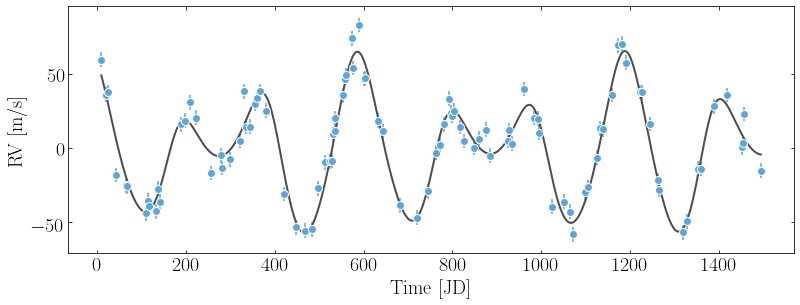

In [30]:
sys.plot_RV()

### Let's initialize another system and try to fit the fake data

In [31]:
sys2 = RVstab.RVSystem(mstar=1.0)
sys2.JDs = JDs
sys2.vels = vels
sys2.errs = errs
sys2.epoch = 0

### RVstab can produce Lomb-Scargle Periodograms to analyze the peridoicity of the RV signal

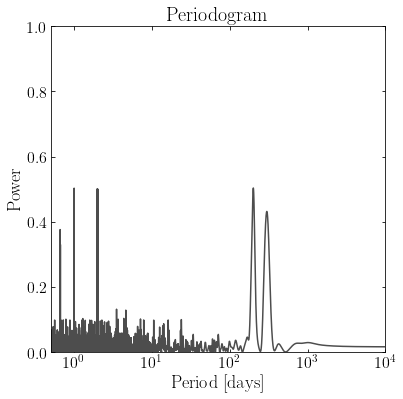

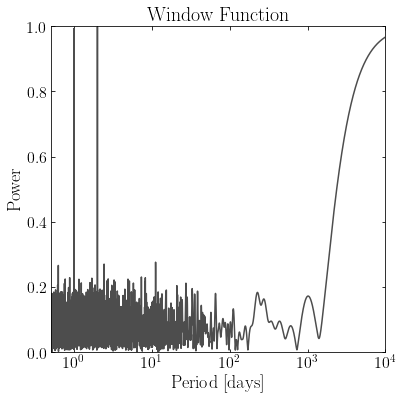

In [32]:
sys2.periodogram(show_res=False)

Unsurprisingly there are two peaks in the periodogram at ~200 and ~300 days. Furthermore from the amplitude of the RV signal we can estimate the mass of the planets, which must be about a Jupiter mass. Starting with that info, let's try a simple optimization to fit the planet's initial angles. We'll assume both planets are on circular orbits for now.

In [33]:
def l_like_2_plan(args):
    
    l_1,l_2 = args
    
    jitter = 1.
    
    P_1 = 200.
    P_2 = 300.
    
    m_1 = 1.
    m_2 = 1.
    
    sys2.clear_planets()
    sys2.add_planet(per=P_1,mass=m_1,l=l_1,omega=0)
    sys2.add_planet(per=P_2,mass=m_2,l=l_2,omega=0)
    
    return -sys2.log_like(jitter=jitter)

In [34]:
a = 0,0
result = scipy.optimize.minimize(l_like_2_plan,a)
print(result.x)

[ 7.46604093 21.48864048]


### Let's see how that did

In [35]:
l_1,l_2 = result.x

jitter = 1.
    
P_1 = 200.
P_2 = 300.

m_1 = 1.
m_2 = 1.

sys2.clear_planets()
sys2.add_planet(per=P_1,mass=m_1,l=l_1,omega=0)
sys2.add_planet(per=P_2,mass=m_2,l=l_2,omega=0)

-566.171814862813


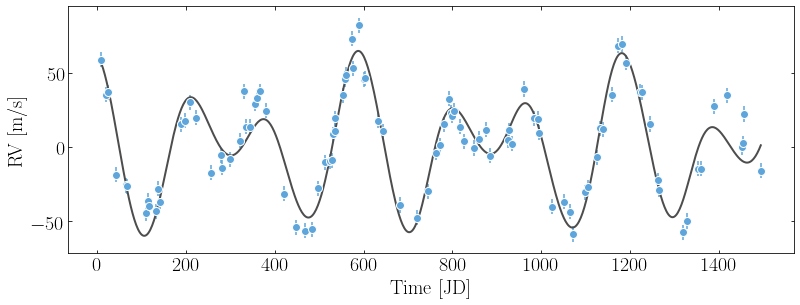

In [36]:
print(sys2.log_like(jitter=jitter))
sys2.plot_RV(jitter=jitter)

### RVstab can be used in tandem with a Markov Chain Monte Carlo (MCMC) search to find the posterior distribution of the oribtal parameters. 

### We'll use the [$\texttt{emcee}$ package](https://emcee.readthedocs.io/en/stable/) to perform the MCMC, using our previous optimiziaton as a starting point. The code also includes a "jitter" term -- this is common in fitting RV observations -- usually there's some unknown amount of error due to stellar noise that's not accounted for in the error bars. Thus, we use a simple model for the stellar noise where there's a unknown amount of stellar jitter $\sigma_j$, and the error bar on each measurement is then $\sqrt{\sigma_i^2 + \sigma_j^2}$, where $\sigma_i$ is the quoted error. For now, we'll leave the jitter at 1 m/s.

### First we define our full likelihood function:

In [37]:
def lnlike(args):
    
    P_1,P_2,m_1,m_2,l_1,l_2,log_e1,log_e2,om_1,om_2 = args
    
    jitter = 1.
    
    sys2.clear_planets()
    sys2.add_planet(per=P_1,mass=m_1,l=l_1,e=10**(log_e1),omega=om_1)
    sys2.add_planet(per=P_2,mass=m_2,l=l_2,e=10**(log_e2),omega=om_2)
    
    return sys2.log_like(jitter=jitter)

### Now we define our priors, which we'll just keep uniform

In [38]:
def lnprior(args):

    bounds = [(10,500),(10,500),(1e-2,10),(1e-2,10),(-360,360),(-360,360),(-4,0),(-4,0),(-360,360),(-360,360)]
    
    for arg, b in zip(args,bounds):
        if not(b[0]<arg<b[1]):
            return -np.inf
    return 0.0

### Now our posterior probability function, which we'll pass to $\texttt{emcee}$

In [39]:
def lnprob(args):
    lp = lnprior(args)
    if not np.isfinite(lp):
        return -np.inf

    return lp + lnlike(args)

### Now all we need is the starting position of our MCMC. We'll use 100 walkers, so we need 100 starting positions. We'll take the starting position from before and add a little bit of noise to it 100 times to generate these starting positions.

In [40]:
ndim,nwalkers = 10,100 #ndim is the number of parameters we're trying to fit, nwalkers is the number of walkers in our MCMC

start = 200,300,1.0,1.0,result.x[0],result.x[1],-1,-1,0,0
pos = [start + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]

### Now run the MCMC for 500 steps (takes ~10 minutes)

In [41]:
import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

In [42]:
_ = sampler.run_mcmc(pos, 500,progress=True)

100%|██████████| 500/500 [04:41<00:00,  1.77it/s]


Now let's plot the results of the MCMC run

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


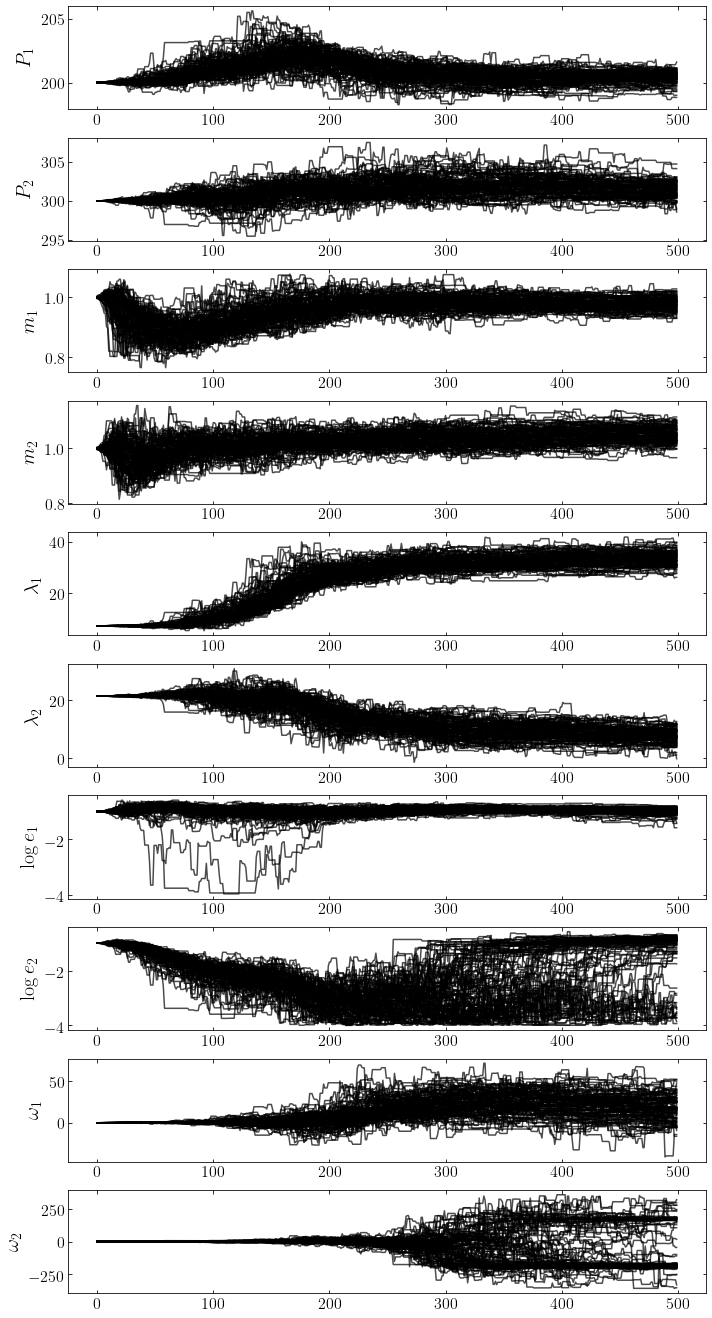

In [43]:
fig = plt.figure(1,figsize=(10,20))

chain = sampler.chain

labels = [r'$P_1$',r'$P_2$',r'$m_1$',r'$m_2$',r'$\lambda_1$',r'$\lambda_2$',r'$\log e_1$',r'$\log e_2$',r'$\omega_1$',\
         r'$\omega_2$',r'$\sigma_j$']

for i in range(len(chain)):
    for j in range(ndim):
        plt.subplot(ndim+1,1,j+1)
        plt.plot(chain[i,:,j],color='k',alpha=0.7)
        plt.ylabel(labels[j])


plt.tight_layout()

In [44]:
best_fit = sampler.get_chain(flat=True)[np.argmax(sampler.get_log_prob(flat=True))]
print(best_fit)

[ 200.34229744  301.06080583    0.97757887    1.05472572   35.54390713
    6.26754405   -0.99630132   -0.84779689    9.78290612 -189.71081166]


-378.0053754109062


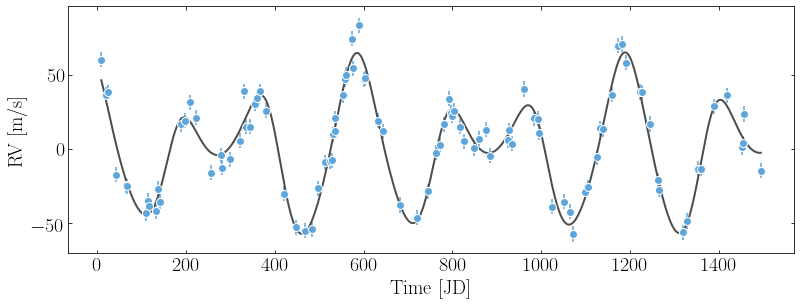

In [45]:
P_1,P_2,m_1,m_2,l_1,l_2,log_e1,log_e2,om_1,om_2 = best_fit
jitter = 1.

sys2.clear_planets()
sys2.add_planet(per=P_1,mass=m_1,l=l_1,e=10**(log_e1),omega=om_1)
sys2.add_planet(per=P_2,mass=m_2,l=l_2,e=10**(log_e2),omega=om_2)

print(sys2.log_like(jitter=jitter))
sys2.plot_RV(jitter=jitter)

### Not too bad, but in order to get a converged posterior, let's start from our best fit and run for 1000 steps, this time allowing the jitter to change as well.

In [46]:
def lnlike(args):
    
    P_1,P_2,m_1,m_2,l_1,l_2,log_e1,log_e2,om_1,om_2,jitter = args
    
    sys2.clear_planets()
    sys2.add_planet(per=P_1,mass=m_1,l=l_1,e=10**(log_e1),omega=om_1)
    sys2.add_planet(per=P_2,mass=m_2,l=l_2,e=10**(log_e2),omega=om_2)
    
    return sys2.log_like(jitter=jitter)

In [47]:
def lnprior(args):

    bounds = [(10,500),(10,500),(1e-2,10),(1e-2,10),(-360,360),(-360,360),(-4,0),(-4,0),(-360,360),(-360,360),(0,30)]
    
    for arg, b in zip(args,bounds):
        if not(b[0]<arg<b[1]):
            return -np.inf
    return 0.0

In [48]:
def lnprob(args):
    lp = lnprior(args)
    if not np.isfinite(lp):
        return -np.inf

    return lp + lnlike(args)

In [49]:
ndim,nwalkers = 11,100 #ndim is the number of parameters we're trying to fit, nwalkers is the number of walkers in our MCMC

start = np.concatenate((best_fit,[5]))
pos = [start + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]

In [50]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)
_ = sampler.run_mcmc(pos, 1000,progress=True)

100%|██████████| 1000/1000 [09:07<00:00,  1.83it/s]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


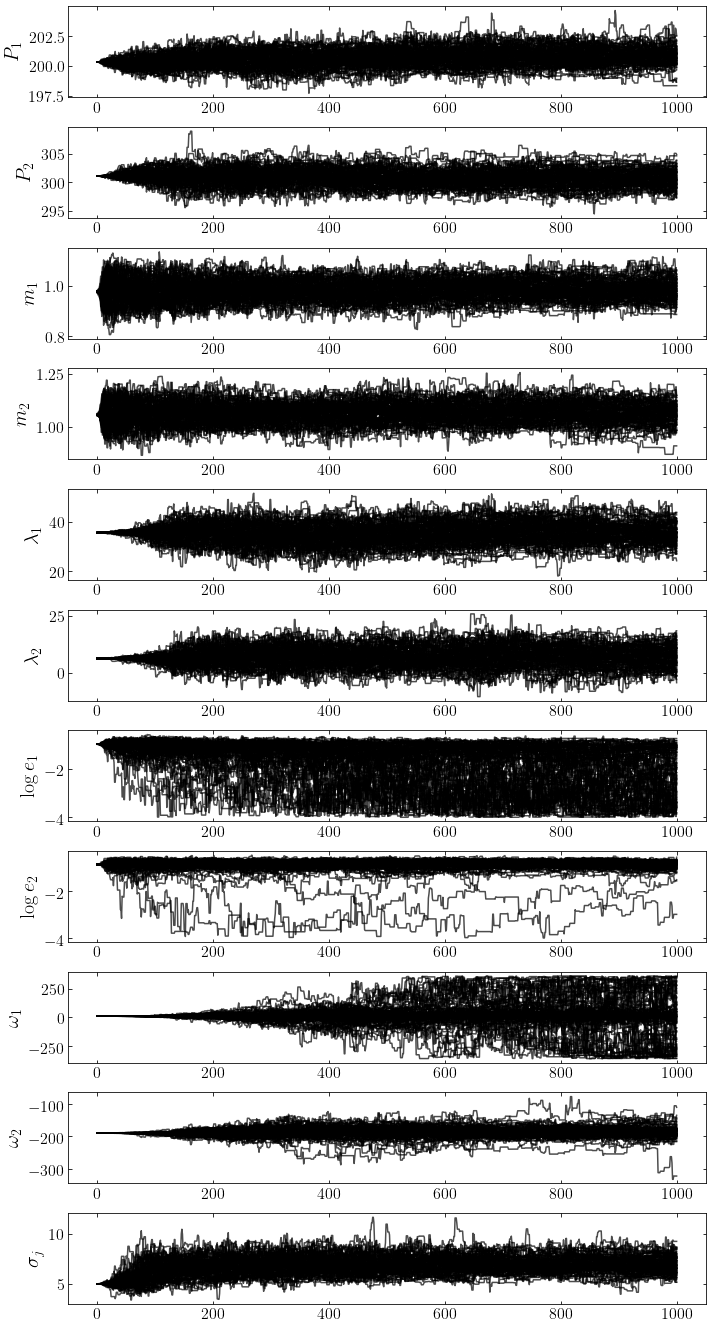

In [51]:
fig = plt.figure(1,figsize=(10,20))

chain = sampler.chain

labels = [r'$P_1$',r'$P_2$',r'$m_1$',r'$m_2$',r'$\lambda_1$',r'$\lambda_2$',r'$\log e_1$',r'$\log e_2$',r'$\omega_1$',\
         r'$\omega_2$',r'$\sigma_j$']

for i in range(len(chain)):
    for j in range(ndim):
        plt.subplot(ndim+1,1,j+1)
        plt.plot(chain[i,:,j],color='k',alpha=0.7)
        plt.ylabel(labels[j])


plt.tight_layout()

The walker positions look much more converged now. We can use the [corner package](https://corner.readthedocs.io/en/latest/) to plot the results. We'll slice off the first 400 positions as the inital burn-in period.

In [52]:
samples = sampler.chain[:,400:,:].reshape(-1,ndim)

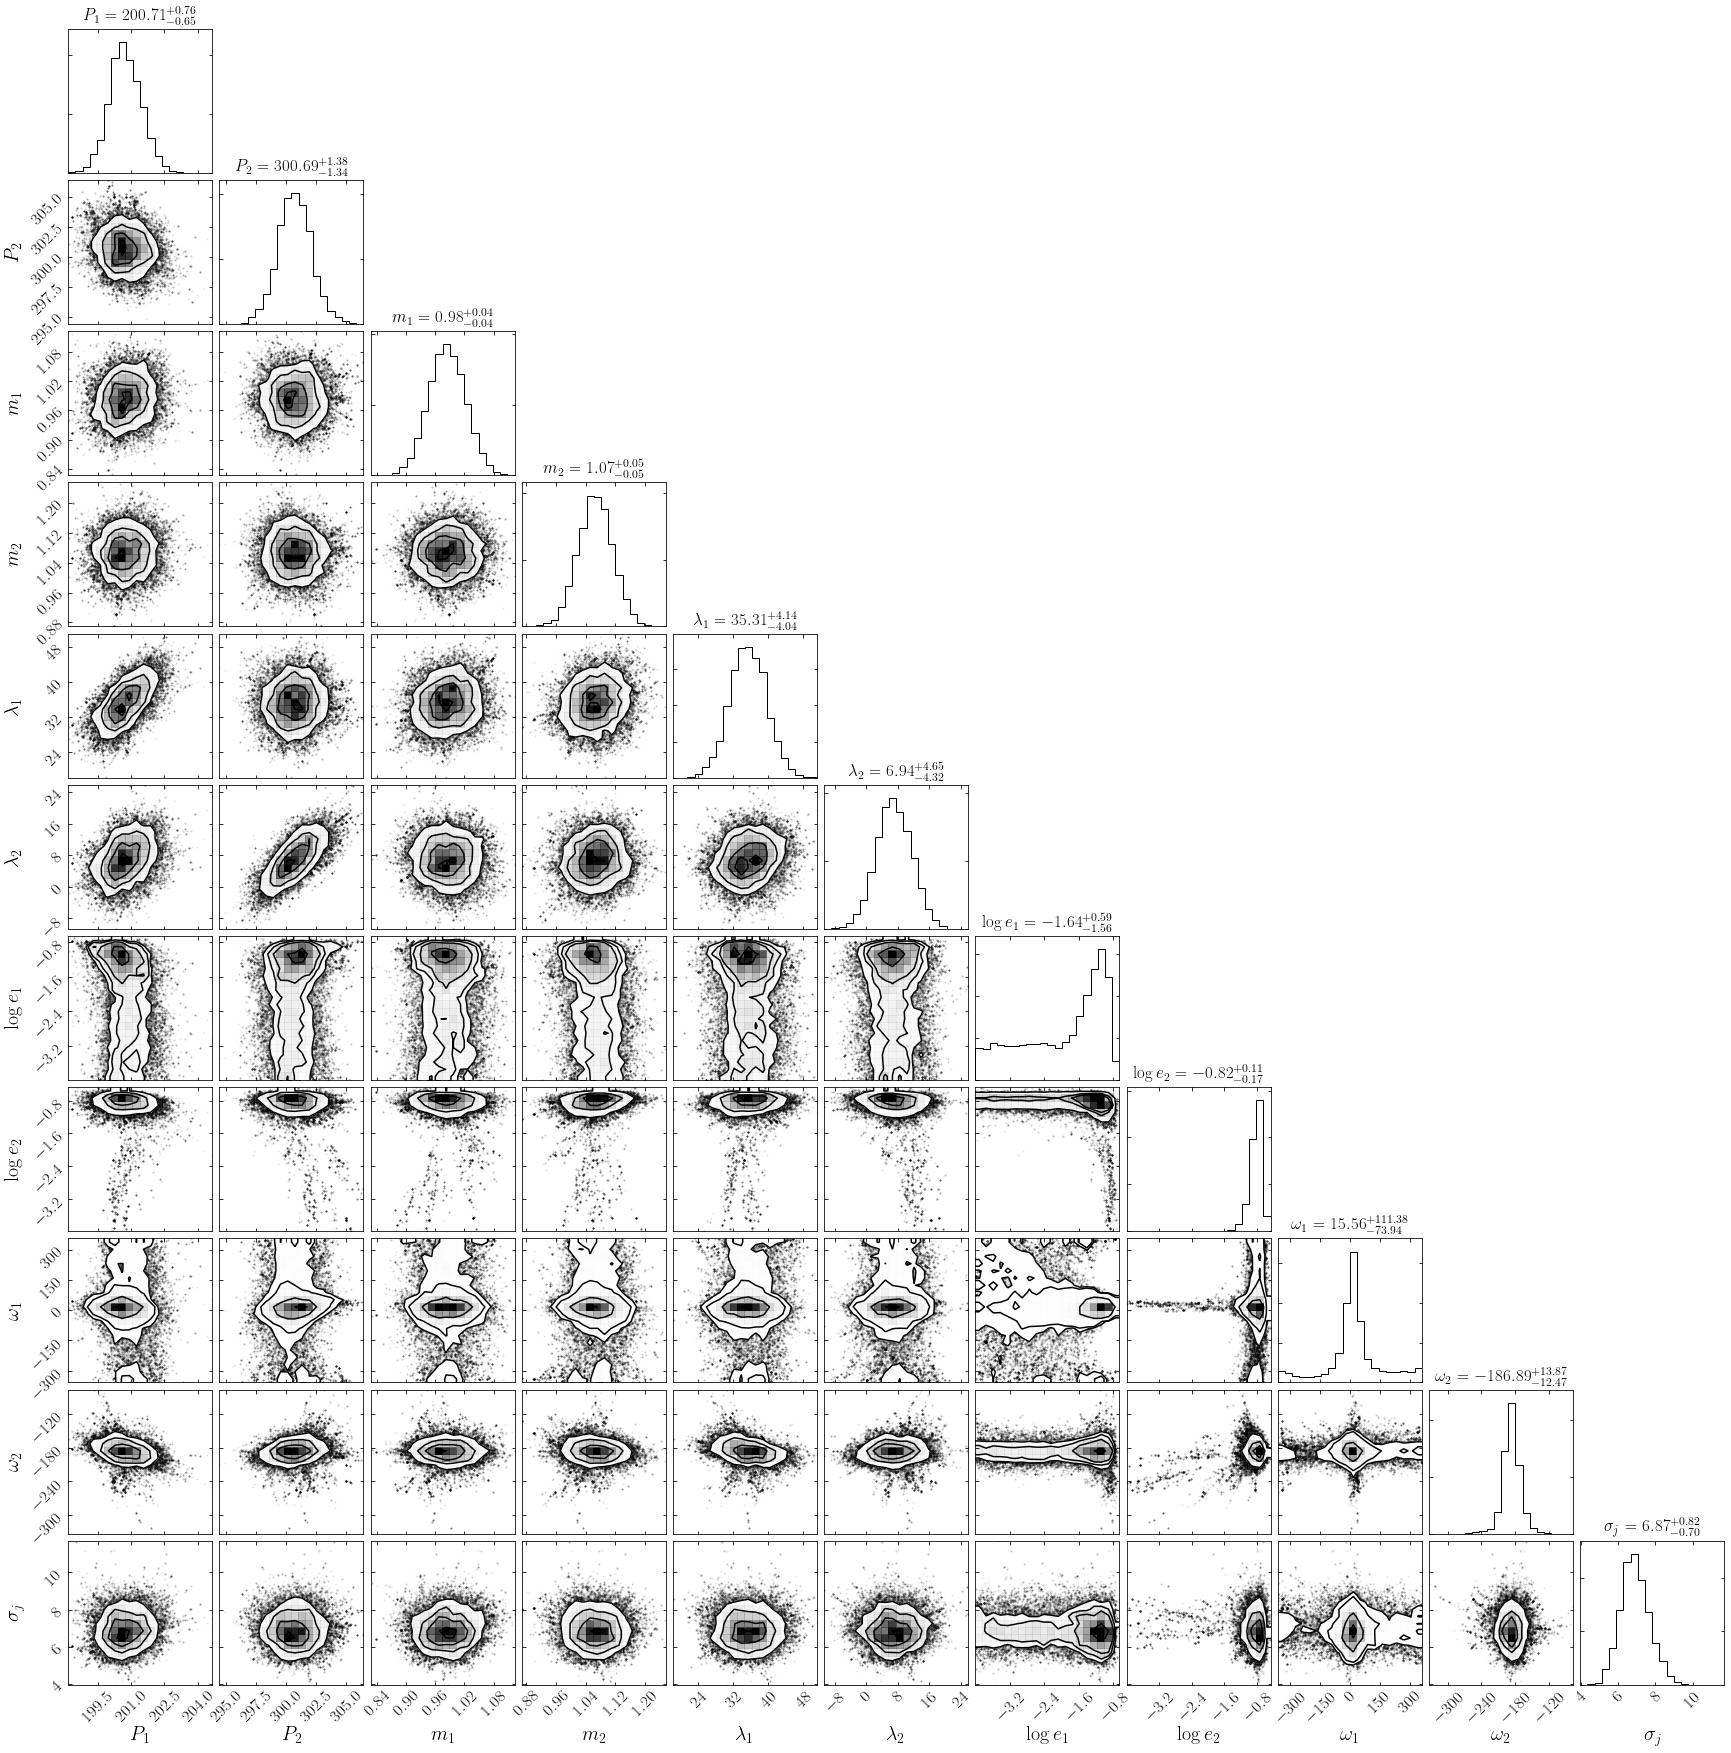

In [53]:
import corner
import matplotlib as mpl

mpl.rcParams['axes.labelsize'] = 20

title_dict = {}
title_dict['fontsize'] = 17

fig = corner.corner(samples,show_titles=True,labels=labels,title_kwargs=title_dict)

for ax in fig.get_axes():
    ax.tick_params(axis='both', labelsize=17)

In [54]:
best_fit = sampler.get_chain(flat=True)[np.argmax(sampler.get_log_prob(flat=True))]
print(best_fit)

[ 200.65347534  300.41361666    0.97385797    1.04647028   34.97155621
    6.25744207   -1.11680795   -0.86664234    7.60621978 -183.39655106
    6.36365259]


-350.1622350933613


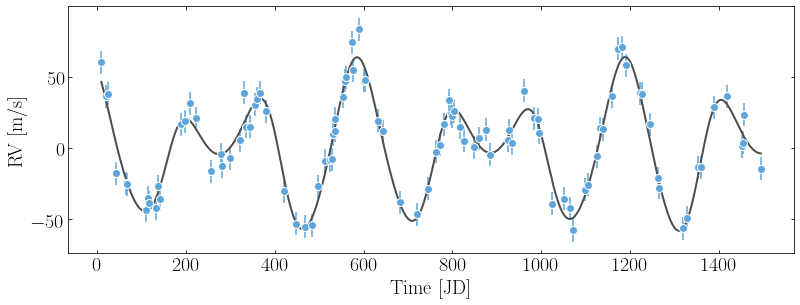

In [55]:
P_1,P_2,m_1,m_2,l_1,l_2,log_e1,log_e2,om_1,om_2,jitter = best_fit

sys2.clear_planets()
sys2.add_planet(per=P_1,mass=m_1,l=l_1,e=10**(log_e1),omega=om_1)
sys2.add_planet(per=P_2,mass=m_2,l=l_2,e=10**(log_e2),omega=om_2)

print(sys2.log_like(jitter=jitter))
sys2.plot_RV(jitter=jitter)

### Finally, we might be concerned that system doesn't exhibit long-term stability, which can be tested with the orbit_stab method, which rules the system as unstable if the semi-major axis of any planet changes by more than 50%. It also takes an optional minimum encounter distance, which we'll set to the mutual hill radius between the two planets:
\begin{align}
M_\mathrm{Hill} = \frac{a_1 + a_2}{2} \left(\frac{M_1 + M_2}{3 M_*}\right)^{1/3}
\end{align}

In [56]:
sim = sys2.ret_sim()
ps = sim.particles

m_star = ps[0].m
a_1 = ps[1].a
a_2 = ps[2].a
m_1 = ps[1].m
m_2 = ps[2].m

d_min = (a_1 + a_2)/2*((m_1+m_2)/(3*m_star))**(1/3)

print("d_min = %.3f au" %d_min)

d_min = 0.067 au


149717
0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
100%


1

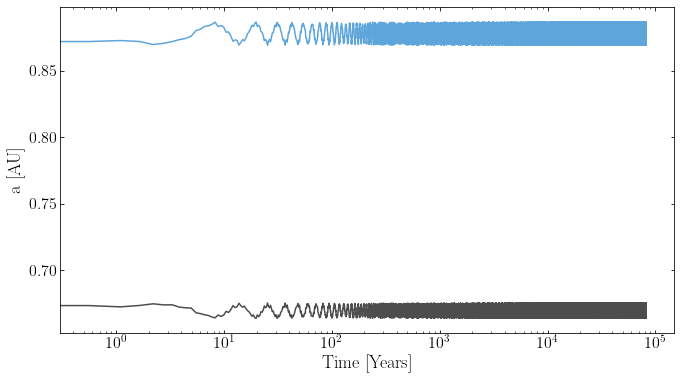

In [57]:
sys2.orbit_stab(periods=1e5,plot=True,verbose=True,d_min=d_min)

### If we want to do an MCMC search conditioned on stability, we simply need to use the stab_logprob function instead of of log_like. Be warned that this will *greatly* increase the time to compute the likelihood if stability is checked over a large number of orbital periods.

In [58]:
sys2.stab_logprob(periods=1e5,d_min=d_min,verbose=True,jitter=jitter)

149717
0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
100%


-350.1622350933613